In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

from sklearn.decomposition import PCA
import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal


# for IWAE
from scipy.stats import multivariate_normal
from matplotlib import ticker, cm
from matplotlib import gridspec
from matplotlib import collections  as mplc
from scipy.special import logsumexp
# end for IWAE

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

# dgm_utils
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data
from seminar6_utils import visualize_2d_map, visualize_samples_pdf

# <center>Deep Generative Models</center>
## <center>Seminar 6</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>17.10.2022</center>


## Plan

3. Normalizing Flows intro
    

## Flows

<center><img src="pics/flows.png" width=800 /></center>

* $A = \mathbb{R}^D$, $p_A$ is the source distribution.

* $B = \mathbb{R}^D$, $p_B$ is the target distribution

* $f(\cdot, \theta) : \mathbb{R}^D \rightarrow \mathbb{R}^D$ is a Diffeomorphism [wiki](https://en.wikipedia.org/wiki/Diffeomorphism)

* Define $g := f^{-1}$. $f = g^{-1}$. $f$ or $g$ could be **unknown**!

**Question**

Can a function $h: \mathbb{R}^D \rightarrow \mathbb{R}^d$, $d \neq D$ be continuous, injective?

### Pushforward transform

$\mathcal{P}_B$ is the distribution of $f(x_A), x_A \sim \mathcal{P}_{A}$. I.e. $\mathcal{P}_{B}(Q) \overset{\text{def.}}{=} \mathcal{P}_{A}(g(Q))$, where $Q$ is a Borel subset of $B$

$\mathcal{P}_B$ is also called **pushforward** of $\mathcal{P}_A$ under $f$:

$$\mathcal{P}_B = f\sharp \mathcal{P}_A$$

**Question**

Is the measure $\mathcal{P}_A$ a pushforward transform of $\mathcal{P}_B$ under some mapping? What is the mapping?

$\mathcal{P}_A = g \sharp \mathcal{P}_B$

### Sampling

**Question**

How to get samples from $\mathcal{P}_B$ given $f$ and $\boldsymbol{X}_A \sim \mathcal{P}_A$?

How to get samples from $\mathcal{P}_A$ given $g$ and $\boldsymbol{X}_B \sim \mathcal{P}_B$?

$f(\boldsymbol{X}_A) \sim \mathcal{P}_B$

$g(\boldsymbol{X}_B) \sim \mathcal{P}_A$

### Change of variable theorem

Let $p_A(x)$ is the pdf of $\mathcal{P}_{A}$. Then 
$$
    p_A(x_A) = p_{B}(f(x_A))  \left\vert \det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x_A} \right) \right\vert
$$

**Equivalent formulations**:

$$
    p_A(x_A) = \frac{p_B(f(x_A))}{\left\vert \det \left(\frac{\partial g(x, \theta)}{\partial x}\Big{|}_{x = f(x_A)} \right) \right\vert}
$$

$$
    p_B(x_B) = p_A(g(x_B)) \left\vert \det \left(\frac{\partial g(x, \theta)}{\partial x}\Big{|}_{x = x_B} \right) \right\vert
$$

$$
    p_B(x_B) = \frac{p_A(g(x_B))}{\left\vert \det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = g(x_B)} \right) \right\vert}
$$

**Question.**

What if $f = f_{K} \circ f_{K-1} \circ \dots \circ f_{1}$?

$p_A(x_A) = p_B(f(x_A)) \left\vert \det \left(\frac{\partial f_1(x, \theta)}{\partial x}\Big{|}_{x = x_A} \right) \right\vert \cdot \left\vert \det \left(\frac{\partial f_2(x, \theta)}{\partial x}\Big{|}_{x = f_1(x_A)} \right) \right\vert \cdot \dots \cdot \left\vert \det \left(\frac{\partial f_K(x, \theta)}{\partial x}\Big{|}_{x = f_{K-1} \circ \dots \circ f_1(x_A)} \right) \right\vert$

### Planar flow

$f(x_A) = x_A + \mathbf{u}h(\mathbf{w}^T x_A + b)$


$\theta = \{\mathbf{u,w} \in \mathbb{R}^D, b \in \mathbb{R}\}$

In [3]:
w = torch.tensor([5., 0.])
u = torch.tensor([1., 0.])
b = 0.

def h(x):
    return torch.tanh(x)

def f(x, w=w, u=u, b=b):
    adj = h(x @ w + b)
    return x + torch.kron(adj.unsqueeze(-1), u)

Samples from $p_A$

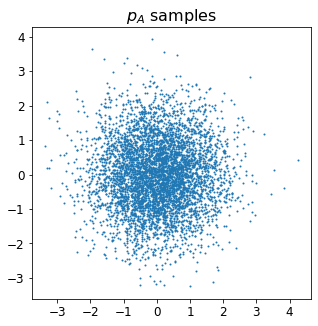

In [4]:
p_A = TD.Normal(torch.tensor([0., 0]), torch.tensor([1., 1.]))
X_A = p_A.sample((5000,))
visualize_2d_samples(X_A, r'$p_A$ samples')

Samples from $p_B$, $p_B = f\sharp p_A$

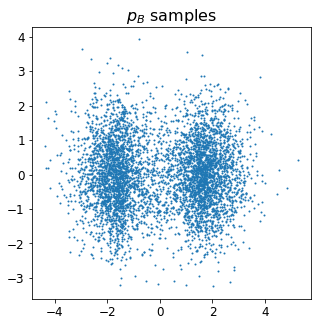

In [5]:
X_B = f(X_A)
visualize_2d_samples(X_B, r'$p_B$ samples')

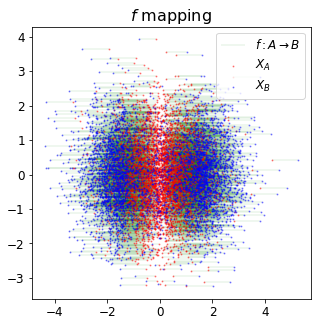

In [6]:
visualize_2d_map(
    X_A, X_B, '$f$ mapping', 
    data_label=r'$X_A$', 
    mapped_data_label=r'$X_B$', 
    map_label=r'$f: A \rightarrow B$')

**Question**

Let $x_B \in \mathbb{R}^D$. What we need to estimate $p_B(x_B)$?

* We need to be sure that the function $f$ is invertible <span style="color:orange"> Stay tuned. Will be considered soon </span>

* We need to know $x_A = g(x_B)$! <span style="color:red"> In general, unsolvable </span>

* We need to calculate $p_A(x_A)$ <span style="color:green"> Easy, as $p_A \sim \mathcal{N}(0, I)$ </span>

* We have to compute $\det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x_A} \right)$ <span style="color:orange"> Stay tuned. Will be considered soon </span>

### Computation of $det J_f$. Straightforward approach

In [7]:
from seminar6_utils import batch_jacobian

X_A.requires_grad_()
X_B = f(X_A)
fjacs_X_A_autograd = batch_jacobian(X_A, X_B)

log_det_fjacs_X_A_autograd = torch.logdet(fjacs_X_A_autograd)

p_B_X_B_autograd = torch.exp(p_A.log_prob(X_A).sum(-1) - log_det_fjacs_X_A_autograd)

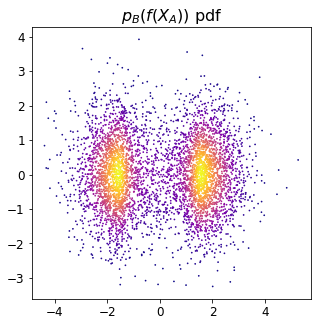

In [8]:
visualize_samples_pdf(X_B, p_B_X_B_autograd, r'$p_B(f(X_A))$ pdf')

### Computation of $det J_f$. Utilize structure of $f_{\theta}$

$x \in \mathbb{R}^D$

$f(x) = x + \mathbf{u}h(\mathbf{w}^T x + b)$


$\theta = \{\mathbf{u,w} \in \mathbb{R}^D, b \in \mathbb{R}\}$

$\left.\dfrac{\partial f(x, \theta)}{\partial x}\right|_{x = x} =  \mathbf{I} + \mathbf{u}h'(\mathbf{w}^T x + b)\mathbf{w}^T$

**Question** How to compute $\det \left(\dfrac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x}\right)$?

#### Matrix detminant lemma

Let $\mathbf{A} \in \mathbb{R}^{D \times D}$ is an invertable matrix. $\mathbf{V}, \mathbf{W} \in \mathbb{R}^{D \times M}$. Then:

$$
\det\left(\mathbf{A} + \mathbf{V} \mathbf{W}^T\right) = \det\left(\mathbf{A}\right) \det \left( \mathbf{I}_{M} + \mathbf{W}^T \mathbf{A}^{-1} \mathbf{V}\right)
$$

**Question** What is $M$ in our case? How to compute the $\det$ using matrix determinant lemma?

$\det \left(\dfrac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x}\right) = \left(1 + h'(\mathbf{w}^T x + b)\mathbf{w}^T\mathbf{I}^{-1}\mathbf{u} \right) \det(\mathbf{I}) = 1 + h'(\mathbf{w}^T x + b)\mathbf{w}^T \mathbf{u}$

**Question** Let $h'(x)$ is bounded, i.e. $\vert h'(x) \vert \leq L$. When $f(x) = x + \mathbf{u}h(\mathbf{w}^T x + b)$ is reversible?

$\mathbf{w}^T\mathbf{u} > -\frac{1}{L}$

In particular, if $h = \tanh$, $\mathbf{w}^T\mathbf{u} > -1$

In [9]:
def h_grad(x):
    return 1./torch.cosh(x).pow(2)

def batch_det_jacobian_analytic(x):
    adj = h_grad(x @ w + b)
    return 1. + adj * (w @ u)

det_fjacs_X_A_analytic = batch_det_jacobian_analytic(X_A)
log_det_fjacs_X_A_analytic = torch.log(det_fjacs_X_A_analytic)

p_B_X_B_analytic = torch.exp(p_A.log_prob(X_A).sum(-1) - log_det_fjacs_X_A_analytic)

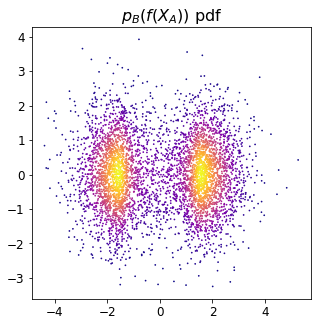

In [10]:
visualize_samples_pdf(X_B, p_B_X_B_analytic, r'$p_B(f(X_A))$ pdf')

In [11]:
torch.allclose(p_B_X_B_analytic, p_B_X_B_autograd)

True

**Conclusion**

Popular recipe to create normalizing flow:

* Come up with $f : A \rightarrow B$ with easy-to-compute $\det J_f$

* Make sure $\det J_f$ is nondegenerate

**Question**

Let we model inverse transform $g: B \rightarrow A$, $g = f^{-1}$ via Planar Flow:

$g(x) = x + \mathbf{u}h(\mathbf{w}^T x + b)$

Let $x_B \in \mathbb{R}^D$. As usual, we suppose $p_A$ is known and $p_B$ is unknown. How to estimate $p_B(x_B)$?

$$
    p_B(x_B) = p_A(g(x_B)) \left\vert \det \left(\frac{\partial g(x, \theta)}{\partial x}\Big{|}_{x = x_B} \right) \right\vert
$$

Can we sample from $p_B$ in this case?

We need to know $x_B = f(x_A) = g^{-1}(x_A)$! <span style="color:red"> In general, unsolvable </span>

## Normalizing flows

<center><img src="pics/flows_how2.png" width=800 /></center>

### Generative properties:

**Sampling**:

1. Sample $z \sim p_z$

2. $x = g(z)$

**pdf estimation**:

$p(x, \theta) = p_z(f(x))  \left\vert \det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x} \right) \right\vert$

#### Linar flow example

$g(\mathbf{z}) = \Sigma \mathbf{z} + b$


$\theta = \{\mathbf{\Sigma} \in PD(\mathbb{R}^{D\times D}), b \in \mathbb{R}\}$

In [50]:
Sigma = torch.tensor([[1., 1.], [-1., 1.]])
b = torch.tensor([0., 0.])

def g(z, Sigma=Sigma, b = b):
    assert len(z.shape) == 2
    return z @ Sigma.T + b



$p_z$ samples

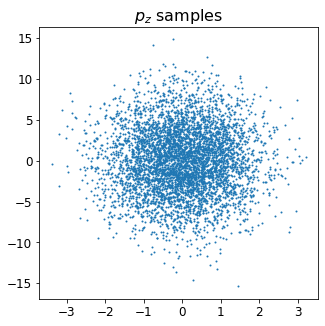

In [55]:
p_z = TD.Normal(torch.tensor([0., 0]), torch.tensor([1., 4.]))
z = p_z.sample((5000,))
visualize_2d_samples(z, r'$p_z$ samples')

$p(x, \theta)$ samples

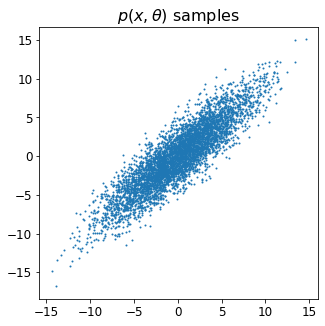

In [56]:
x = g(z)
visualize_2d_samples(x, r'$p(x, \theta)$ samples')

In [57]:
def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return torch.autograd.functional.jacobian(
        _func_sum, x, create_graph=create_graph).permute(1,0,2)

jacs = batch_jacobian(g, z)
log_det_jacs = torch.logdet(jacs)